# Introduction to Data Science
## Homework 4 

Student Name: Wenjie Sun

Student Netid: ws854
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 Points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

<b>Grading guideline: if this function is done in more than 20 lines (not including empty lines), we will deduct 2 points.</b>

In [1]:
import pandas as pd 
import numpy as np
from sklearn import preprocessing 

def cleanBosonData(infile_name): 
    dataframe = pd.read_csv (infile_name+'.csv')
    dataframe = dataframe.set_index('EventId')
    dataframe['Y'] = dataframe['Label']
    count_lable = pd.value_counts(dataframe.Y.values,sort = True)
    
    if count_lable.ix['s']> count_lable.ix['b']:
        dataframe.Y = dataframe.Y.replace({'b':1,'s':0})
    else:
        dataframe.Y = dataframe.Y.replace({'b':0,'s':1})        
    data_clean = dataframe.drop('Label',axis = 1)
    
    for features in data_clean:
        if -999 in data_clean[features].values:
            data_clean[features+'_mv'] = data_clean[features].replace({-999:1})
            mean = data_clean[features+'_mv'].replace({1:np.NaN}).mean()
            data_clean[features+'_mv'] = data_clean[features+'_mv'].replace({1:mean})
            data_clean = data_clean.drop(features,axis=1)
            
            #data_clean[features+'_mv'] = preprocessing.scale(data_clean[features+'_mv'],with_mean = True, with_std=True)
        elif features != 'Y':
            data_clean[features] = preprocessing.scale(data_clean[features],with_mean = True, with_std=True)    
    return data_clean


#print (cleanBosonData("boson_training_cut_2000"))

### Part 2: Basic evaluations (5 Points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [2]:
#Student put code here
data_train = cleanBosonData("boson_training_cut_2000")
data_test = cleanBosonData("boson_testing_cut")

# data_train = cleanBosonData("C:/Users/Wenjie Sun/Documents/Wsun/New folder/ids4/boson_training_cut_2000")
# data_test = cleanBosonData("C:/Users/Wenjie Sun/Documents/Wsun/New folder/ids4/boson_testing_cut")



2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score

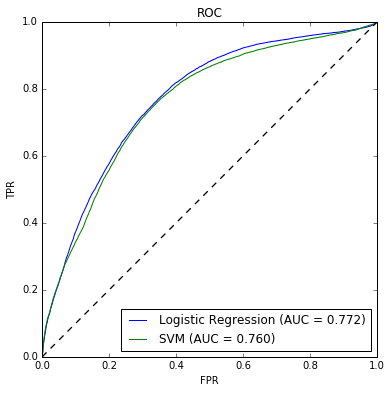

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score


data_train_feature = data_train.drop('Y',axis = 1)
data_train_target = data_train['Y']

data_test_feature = data_test.drop('Y',axis = 1)
data_test_target = data_test['Y']


clf_lr = linear_model.LogisticRegression(C=1e30)
clf_lr.fit(data_train_feature,data_train_target) 
predict_lr = clf_lr.predict(data_test_feature)
posProb_lr = [i[1] for i in clf_lr.predict_proba(data_test_feature)]


clf_svm = svm.SVC(kernel = 'linear', probability = True)
clf_svm.fit(data_train_feature,data_train_target)
predict_svm = clf_svm.predict(data_test_feature)
posProb_svm = [i[1] for i in clf_svm.predict_proba(data_test_feature)]


def plotUnivaiateROC(preds,truth,label_string):
    fpr,tpr,thresholds = roc_curve(truth,preds,pos_label = 1)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
fig = plt.figure(figsize = (6, 6))
ax = plt.subplot(111)

plotUnivaiateROC(posProb_lr ,data_test_target,"Logistic Regression")
plotUnivaiateROC(posProb_svm,data_test_target,"SVM")

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

#### Answer: Logistic Regression is generally better than SVM.  However, it seems that when FPR is lower than 0.1 or greater than 0.95, SVM performes slightly better than LR. 


### Part 3: Model selection with cross-validation (7 Points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

<b>Grading guideline: if this function is done in more than 20 lines (not including empty lines), we will deduct 2 points.</b>

In [5]:
from sklearn import cross_validation

def xValSVM(dataset, label_name, k, cs):
    cv = cross_validation.KFold(dataset.shape[0],n_folds = k)
    auc_dict = {}
    for c in cs:
        auc_dict[c] = []

    for traincv,testcv in cv: 
        train_this_round = dataset.iloc[traincv]
        test_this_round = dataset.iloc[testcv]
        for c in cs: 
            clf_svm_1 = svm.SVC(kernel='linear', C= c )
            clf_svm_1.fit(train_this_round.drop(label_name,1),train_this_round[label_name])
            posProb_svm_1 =  clf_svm_1.decision_function(test_this_round.drop(label_name,1))      
            fpr,tpr,thresholds = roc_curve(test_this_round[label_name],posProb_svm_1)
            AUC_c_k = auc(fpr,tpr)
            auc_dict[c].append(AUC_c_k)

    return auc_dict

# code ref: http://stackoverflow.com/questions/16379313/how-to-use-the-a-k-fold-cross-validation-in-scikit-with-naive-bayes-classifier-a

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^2]` (i.e., do all powers of 10 from -8 to 2).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [6]:
#Remark: I could not run 10^1 and 10^2.. 
cs = [10**i for i in range(-8,3)] #(-8,3)
acus = xValSVM(data_train, "Y", 10, cs) #10

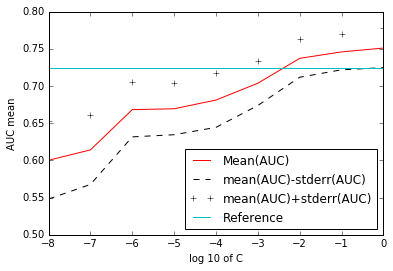

max(mean(AUC)) when c = 1


In [7]:
xval_dict = {'key':[], 'mean':[], 'StdErr':[]}
for i in range(-8,1): #-8,3
    xval_dict['key'].append(i)
    xval_dict['mean'].append(np.array(acus[10 ** i]).mean())
    xval_dict['StdErr'].append(np.sqrt(np.array(acus[10 ** i]).var()))
    
max_key=(xval_dict['key'][(xval_dict['mean'].index(max(xval_dict['mean'])))])
max_c= 10**max_key       
mean_max= (xval_dict['mean'][(xval_dict['mean'].index(max(xval_dict['mean'])))])
std_max = (xval_dict['StdErr'][(xval_dict['mean'].index(max(xval_dict['mean'])))]) 
max_1std = mean_max -std_max

xval_df = pd.DataFrame(xval_dict)
xval_df['min'] = xval_df['mean'] - xval_df['StdErr']
xval_df['add'] = xval_df['mean'] + xval_df['StdErr']
xval_df['reference'] = max_1std
figure = plt.figure()
plt.plot(xval_df['key'], xval_df['mean'], 'r', label = 'Mean(AUC)')
plt.plot(xval_df['key'], xval_df['min'], 'k--', label = "mean(AUC)-stderr(AUC)")
plt.plot(xval_df['key'], xval_df['add'], 'k+', label = "mean(AUC)+stderr(AUC)")
plt.plot(xval_df['key'], xval_df['reference'], 'c', label = 'Reference')

plt.legend(loc = 'lower right')

plt.xlabel("log 10 of C")
plt.ylabel("AUC mean")

plt.show()
         
print ("max(mean(AUC)) when c =",max_c)

#### Answer: It doesn't look like so since the avg. of the AUC (even within 1 StdErr)has not improved much from the previous one. 